In [1]:
import math
import xml.etree.ElementTree as ET
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import csv

In [2]:
class TrackPoint:
    
    def __init__(self, time, lat, lon):
        self.time = time
        self.lat = lat # latitude
        self.lon = lon # longitude


class Track:
    
    def __init__(self):
        self.points = [] # track points

    def gps_distance(self, p1, p2):
        # Haversine Formula
        lat1, lon1 = p1.lat, p1.lon
        lat2, lon2 = p2.lat, p2.lon
        Earth_radius = 6371  # km
        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = (math.sin(0.5 * dlat) * math.sin(0.5 * dlat) +
             math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
             math.sin(0.5 * dlon) * math.sin(0.5 * dlon))
        return 2 * Earth_radius * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    @property
    def size(self):
        return len(self.points)
    
    @property
    def is_epmty(self):
        return self.size == 0
    
    @property
    def has_bad_timing(self):
        dt, dd, dv = self.segments
        bad_timing = False
        for t in dt:
            if t > 5 * 60:
                # GPS tracker didn't respond for more than 5 minutes
                bad_timing = True
                break
        return bad_timing
    
    @property
    def has_small_distance(self):
        # total distance is less than 100 m
        return self.travel_distance < 0.1
    
    @property
    def origin(self):
        return None if self.is_epmty else self.points[0]
    
    @property
    def destination(self):
        return None if self.is_epmty else self.points[-1]
    
    @property
    def idle_time(self):
        t = 0.0
        if not self.is_epmty:
            ts, ds, _ = self.segments
            n = len(ts)
            if n > 0:
                for i in range(n):
                    if ds[i] == 0:
                        t += ts[i]
        return t
    
    @property
    def travel_time(self):
        return 0 if self.is_epmty else (self.destination.time - self.origin.time).seconds
    
    @property
    def travel_distance(self):
        td = 0.0
        if not self.is_epmty:
            _, dd, _ = self.segments
            td = sum(dd)
        return td
    
    @property
    def mean_speed(self):
        ms = 0.0
        if not self.is_epmty:
            _, _, vs = self.segments
            if len(vs) != 0:
                ms = 1.0 * sum(vs) / len(vs)
        return ms
    
    @property
    def aver_speed(self):
        return 0 if self.travel_time == 0 else 3600 * self.travel_distance / self.travel_time
    
    @property
    def segments(self):
        dt, dist, velocity = [], [], []
        if not self.is_epmty:
            for i in range(self.size - 1):
                dt.append((self.points[i + 1].time - self.points[i].time).seconds)
                dist.append(self.gps_distance(self.points[i], self.points[i + 1]))
                velocity.append(3600.0 * dist[-1] / dt[-1])
        return dt, dist, velocity
    

class GPX:
    
    def __init__(self, file_name):
        tree = ET.parse(file_name)
        self.tracks = self.get_tracks(tree)    
    
    def get_tracks(self, tree):
        trks = []
        root = tree.getroot()
        for trk in root:
            # print trk.tag, trk.attrib
            for trkseg in trk:
                tr = Track()
                for trkpt in trkseg:
                    tstr = trkpt[0].text # 2017-05-31T22:03:41Z
                    year, month, day = tstr[:4], tstr[5:7], tstr[8:10]
                    hour, minute, sec = tstr[11:13], tstr[14:16], tstr[17:19]
                    time = datetime(int(year), int(month), int(day), 
                                    int(hour), int(minute), int(sec))
                    if tr.is_epmty or time != tr.points[-1].time: # exclude repetitions
                        tr.points.append(TrackPoint(time=time,
                                                    lat=float(trkpt.attrib.get('lat')),
                                                    lon=float(trkpt.attrib.get('lon'))))
                # print "Points in track:", len(tr.points)
                trks.append(tr)
        return trks

In [3]:
gpx = GPX('wavelo_low_speed.gpx')

In [ ]:
def plot_track(gpx, idx):
    tr = gpx.tracks[idx - 1]
    ts, ds, vs = [0], [0], [0]
    dt, dd, dv = tr.segments
    #
    track_time, track_dist = 0, 0
    cds = [0] # cumulative distance
    for (t, d) in zip(dt, dd):
        track_time += t / 60.0
        track_dist += d
        ts.append(track_time)
        cds.append(track_dist)
    ds.extend(dd)
    vs.extend(dv)
    plt.plot(ts, cds)
    plt.show()
    plt.plot(ts, vs)
    plt.show()

plot_track(gpx, 1)

In [3]:
class Trip:
    
    def __init__(self, trip_id, duration, distance, idle):
        self.id = trip_id
        self.duration = duration
        self.distance = distance
        self.idle = idle
        
    @property
    def aver_velocity(self):
        return 0.0 if self.duration == 0 else 3600.0 * self.distance / self.duration
    
    @property
    def pure_velocity(self):
        return 0.0 if self.duration == 0 or self.duration == self.idle \
                   else 3600.0 * self.distance / (self.duration - self.idle)

In [23]:
def plot_normal(xs, bins=100):
    m, s = stats.norm.fit(xs)
    print "Normal distribution parameters:", m, s
    
    lnspc = np.linspace(xs.min(), xs.max(), len(xs))
    pdf_g = stats.norm.pdf(lnspc, m, s)
    
    plt.hist(xs, bins=bins, density=True)
    plt.xlabel("Variable values")
    plt.ylabel("Density function")
    plt.plot(lnspc, pdf_g)
    plt.show()
    
def plot_gamma(xs):
    a, b, c = stats.gamma.fit(xs)
    print a, b, c
    
    lnspc = np.linspace(xs.min(), xs.max(), len(xs))
    pdf_gamma = stats.gamma.pdf(lnspc, a, b, c)
    
    plt.hist(xs, bins=100, density=True)
    plt.plot(lnspc, pdf_gamma, label="gamma")
    plt.show()
    
def plot_expon(xs):
    _, b = stats.expon.fit(xs, floc=0)
    print b
    
    lnspc = np.linspace(xs.min(), xs.max(), len(xs))
    pdf_expon = stats.expon.pdf(lnspc, scale=b)
    
    plt.hist(xs, bins=100, density=True)
    plt.plot(lnspc, pdf_expon, label="expon")
    plt.show()

In [24]:
sturges = lambda sample: 1 + int(1.44 * math.log(len(sample)))
    
def bounds(sample):
    # define the bins number
    k = sturges(sample)
    # define the minimum value and the bins width
    x_min = min(sample)
    h = 1.0 * (max(sample) - x_min) / k
    return [(x_min + (i - 1) * h,
             x_min + i * h) for i in range(1, k + 1)]

def efreqs(sample):
    # define the list of bounds
    bs = bounds(sample)
    # take the bins number
    k = len(bs)
    # initialize the resulting variable
    res = [0 for _ in range(k)]
    for x in sample:
        for i in range(k - 1):
            if x >= bs[i][0] and x < bs[i][1]:
                res[i] += 1
        if x >= bs[k - 1][0]:
            res[k - 1] += 1
    return res
    
def tfreqs_normal(sample):
    n = len(sample)
    bs = bounds(sample)
    mean_x = 1.0 * sum(sample) / n
    sd_x = math.sqrt(1.0 * sum([(x - mean_x)**2 for x in sample]) / n)
    cdfs = [ (stats.norm.cdf(b[0], mean_x, sd_x), \
              stats.norm.cdf(b[1], mean_x, sd_x)) for b in bs] 
    return [round(n * (cdf[1] - cdf[0]), 2) for cdf in cdfs]

def tfreqs_expon(sample):
    n = len(sample)
    bs = bounds(sample)
    mean_x = 1.0 * sum(sample) / n
    #sd_x = math.sqrt(1.0 * sum([(x - mean_x)**2 for x in sample]) / n)
    cdfs = [ (stats.expon.cdf(b[0], scale=mean_x), \
              stats.expon.cdf(b[1], scale=mean_x)) for b in bs] 
    return [round(n * (cdf[1] - cdf[0]), 2) for cdf in cdfs]

def check_normal(sample, prob=0.05):
    efs = efreqs(sample)
    tfs = tfreqs_normal(sample)
    k = len(efs)
    print "Sample size: ", len(sample)
    print "Number of bins: ", k
    chi2 = []
    for i in range(k):
        chi2.append((efs[i] - tfs[i]) ** 2 / tfs[i])
    chi2test = sum(chi2)
    print "Normal chi2test:", chi2test, stats.chi2.ppf(1 - prob, k - 2 - 1), chi2test <= stats.chi2.ppf(1 - prob, k - 2 - 1)
    return chi2test <= stats.chi2.ppf(1 - prob, k - 2 - 1)

def check_expon(sample, prob=0.05):
    efs = efreqs(sample)
    tfs = tfreqs_expon(sample)
    k = len(efs)
    print "Sample size: ", len(sample)
    print "Number of bins: ", k
    chi2 = []
    for i in range(k):
        chi2.append((efs[i] - tfs[i]) ** 2 / tfs[i])
    chi2test = sum(chi2)
    print "Expon chi2test:", chi2test, stats.chi2.ppf(1 - prob, k - 1 - 1), chi2test <= stats.chi2.ppf(1 - prob, k - 1 - 1)
    return chi2test <= stats.chi2.ppf(1 - prob, k - 1 - 1)

Normal distribution parameters: 9.33098653375 3.9670171917


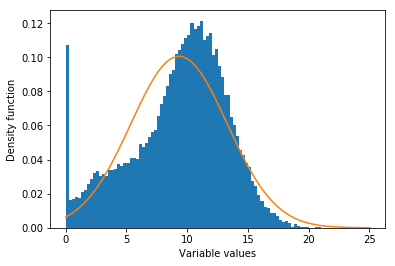

Sample size:  34969
Number of bins:  16
Normal chi2test: 5280.39346038 22.3620324948 False


False

In [6]:
# load all trips
trips = np.array([])

with open('sample_all.txt', 'r') as csvfile:
    trips_reader = csv.reader(csvfile, delimiter=',', quotechar='.')
    idx = 0
    for data in trips_reader:
        idx += 1
        trips = np.append(trips, Trip(idx, float(data[1]), float(data[2]), float(data[4])))

vs = np.array([trip.aver_velocity for trip in trips])
plot_normal(vs)
check_normal(vs)

In [12]:
bad_indices = []

with open('bad_indices.txt', 'r') as csvfile:
    for data in csv.reader(csvfile, delimiter=',', quotechar='.'):
        bad_indices.append(int(data[0]))
print len(bad_indices)

5946


In [13]:
good_data_trips = np.array([])
for trip in trips:
    if not (trip.id in bad_indices):
        good_data_trips = np.append(good_data_trips, trip)
print len(good_data_trips)

29023


Normal distribution parameters: 10.301082457 3.46665850725


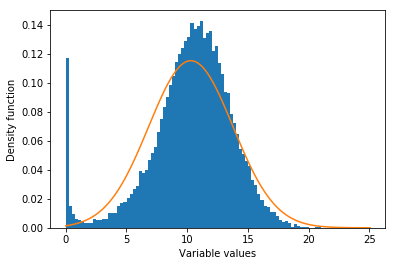

Sample size:  29023
Number of bins:  15
Normal chi2test: 9071.34300706 21.0260698175 False


False

In [14]:
vs = np.array([trip.aver_velocity for trip in good_data_trips])
plot_normal(vs)
check_normal(vs)

40 635 28348
Normal distribution parameters: 10.5463636288 3.11721882185


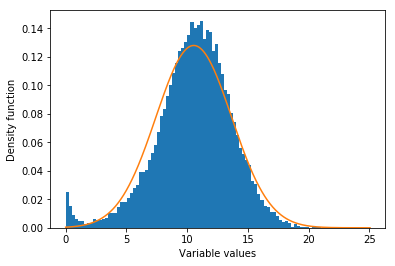

Sample size:  28348
Number of bins:  15
Normal chi2test: 4049.25118062 21.0260698175 False


False

In [15]:
# exclude 'zero' trips
trips_no_zeros = np.array([])
dur_zero, dist_zero = 0, 0
for trip in good_data_trips:
    if trip.duration == 0:
        dur_zero += 1
    elif trip.distance == 0:
        dist_zero += 1
    else:
        trips_no_zeros = np.append(trips_no_zeros, trip)
print dur_zero, dist_zero, len(trips_no_zeros)
vs = np.array([trip.aver_velocity for trip in trips_no_zeros])
plot_normal(vs)
check_normal(vs)

3.82880859375


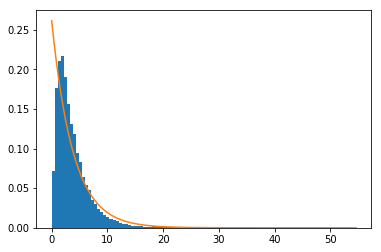

In [28]:
ds = np.array([trip.distance for trip in trips_no_zeros]) # if trip.distance < 0.1])
plot_expon(ds)
# plot_gamma(ds)

Normal distribution parameters: 10.698129396 2.88253484588


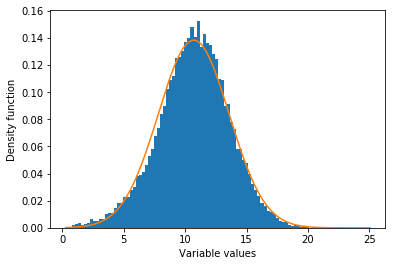

Sample size:  27927
Number of bins:  15
Normal chi2test: 379.167918404 21.0260698175 False


False

In [34]:
trips_implemented = [trip for trip in trips_no_zeros if trip.distance > 0.05]
vs = np.array([trip.aver_velocity for trip in trips_implemented])
plot_normal(vs)
check_normal(vs, prob=0.05)
# plot_normal(vs, bins=15)

3.886328125


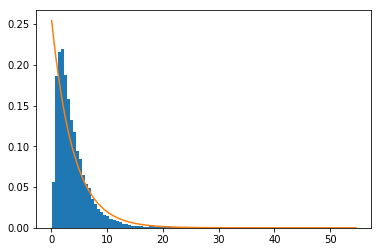

Sample size:  27927
Number of bins:  15
Expon chi2test: 776.458942589 22.3620324948 False


False

In [32]:
ds = np.array([trip.distance for trip in trips_implemented])
plot_expon(ds)
# plot_gamma(ds)
check_expon(ds)

1315.87402344


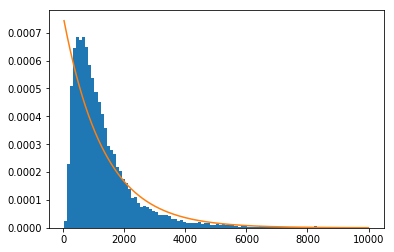

1.78039785598 29.8694367859 721.406922994


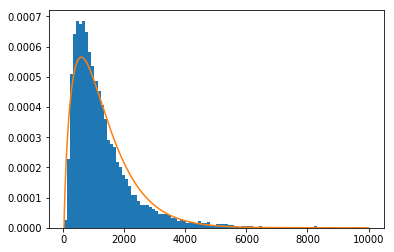

Sample size:  27769
Number of bins:  15
Expon chi2test: 2280.44256292 22.3620324948 False


False

In [33]:
ts = np.array([trip.duration for trip in trips_implemented if trip.duration < 10000])
plot_expon(ts)
plot_gamma(ts)
check_expon(ts)